In [1]:
# Install Required Libraries

# !pip install -U ydata-profiling[notebook]==4.0.0 matplotlib==3.5.1
# !pip install category_encoders
# !pip install -U imbalanced-learn
# !pip install pycaret

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from pandas.tseries.offsets import DateOffset
# from ydata_profiling import ProfileReport
import seaborn as sns

# **Data Cleaning**

Let's begin by loading the data files to gain a better understanding of the data and address any necessary data type corrections.

In [3]:
# Reading data
df_install = pd.read_csv('installs.txt', sep='\t')
df_start_target = pd.read_csv('app starts july.txt', sep='\t')
df_start = pd.read_csv('app starts.txt', sep='\t')
df_view_target = pd.read_csv('brochure views july.txt', sep='\t')
df_view = pd.read_csv('brochure views.txt', sep='\t')

There are 3 types of events in the dataset:
- Install
- Start
- View

## Install Events

In [4]:
df_install.head(5)

,id,InstallDate,productId,userId,model,campaignId
0,37371890,2017-05-04 10:06:27.8070000,de.kaufda.kaufda,5fc13850-de51-4426-96ce-72aaec895abb,"ipad2,7",000000
1,36979918,2017-04-24 09:27:16.1730000,com-bonial-kaufda,b13a035e-e9bf-49db-8f93-b49d491bef53,sm-g800f,3iikhy
2,37371070,2017-05-04 16:05:09.5680000,de.kaufda.kaufda,5deb0aad-43bb-4ee1-868b-98f36c3d5bbf,"iphone8,4",tl3cy8
3,36897929,2017-04-22 13:18:18.4370000,com-bonial-kaufda,64707e97-d5e1-4622-a89a-bebf8432fd33,sm-g955f,000000
4,36606053,2017-04-15 14:03:51.1990000,com-bonial-kaufda,770a391d-eda5-423b-b672-845f1e12661f,sm-j320h,000000


In [5]:
# Checking data types
df_install.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           20000 non-null  int64 
 1   InstallDate  20000 non-null  object
 2   productId    20000 non-null  object
 3   userId       20000 non-null  object
 4   model        19963 non-null  object
 5   campaignId   20000 non-null  object
dtypes: int64(1), object(5)
memory usage: 937.6+ KB


In [6]:
# Fixing data types
df_install['InstallDate'] = pd.to_datetime(df_install['InstallDate'], format='%Y-%m-%d %H:%M:%S.%f').dt.normalize() # Truncating to date
df_install = df_install.convert_dtypes()

In [7]:
df_install.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           20000 non-null  Int64         
 1   InstallDate  20000 non-null  datetime64[ns]
 2   productId    20000 non-null  string        
 3   userId       20000 non-null  string        
 4   model        19963 non-null  string        
 5   campaignId   20000 non-null  string        
dtypes: Int64(1), datetime64[ns](1), string(4)
memory usage: 957.2 KB


In [8]:
df_install.describe(include='all', datetime_is_numeric=True)

,id,InstallDate,productId,userId,model,campaignId
count,20000.0,20000,20000,20000,19963,20000
unique,<NA>,NaN,3,20000,1210,933
top,<NA>,NaN,com-bonial-kaufda,5fc13850-de51-4426-96ce-72aaec895abb,gt-i9195,000000
freq,<NA>,NaN,9726,1,1019,13376
mean,37261288.4112,2017-04-30 19:15:23.040000,NaN,NaN,NaN,NaN
min,35988953.0,2017-04-01 00:00:00,NaN,NaN,NaN,NaN
25%,36653540.75,2017-04-16 00:00:00,NaN,NaN,NaN,NaN
50%,37248431.0,2017-05-01 00:00:00,NaN,NaN,NaN,NaN
75%,37900099.75,2017-05-16 00:00:00,NaN,NaN,NaN,NaN
max,38506835.0,2017-05-31 00:00:00,NaN,NaN,NaN,NaN


As we expect to have one install record for each user, let's assess this assumption.

In [9]:
# Checking duplicates in installs
df_install.groupby('userId').filter(lambda x: len(x) > 2)

,id,InstallDate,productId,userId,model,campaignId


## View Events

In [10]:
df_view.head(5)

,id,userId,dateCreated,page_turn_count,view_duration,brochure_id
0,6269194661,9491a960-206a-4a58-9177-e78cb1f05e70,2017-04-30 23:47:09.5390000,30,95172.0,672239440
1,6269192581,9491a960-206a-4a58-9177-e78cb1f05e70,2017-04-30 23:47:00.6970000,2,4000.0,673861625
2,6269188351,9491a960-206a-4a58-9177-e78cb1f05e70,2017-04-30 23:46:39.9170000,1,14000.0,660764240
3,6204426632,fa623647-dfc9-49b4-bbb6-77cbacd599f4,2017-04-30 23:46:13.5970000,64,168000.0,672658544
4,6204424112,9491a960-206a-4a58-9177-e78cb1f05e70,2017-04-30 23:46:02.1970000,1,33000.0,660764240


In [11]:
df_view.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279213 entries, 0 to 279212
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               279213 non-null  int64  
 1   userId           279213 non-null  object 
 2   dateCreated      279213 non-null  object 
 3   page_turn_count  279213 non-null  int64  
 4   view_duration    269602 non-null  float64
 5   brochure_id      279213 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 12.8+ MB


In [12]:
# Fixing data types
df_view['dateCreated'] = pd.to_datetime(df_view['dateCreated'], format='%Y-%m-%d %H:%M:%S.%f').dt.normalize() # truncating to date
df_view = df_view.convert_dtypes()

df_view_target['dateCreated'] = pd.to_datetime(df_view_target['dateCreated'], format='%Y-%m-%d %H:%M:%S.%f').dt.normalize() # truncating to date
df_view_target = df_view_target.convert_dtypes()

In [13]:
df_view.describe(include='all',datetime_is_numeric=True)

,id,userId,dateCreated,page_turn_count,view_duration,brochure_id
count,279213.0,279213,279213,279213.0,269602.0,279213.0
unique,<NA>,10943,NaN,<NA>,<NA>,<NA>
top,<NA>,9bf3ab9b-4f07-4e54-ac21-d92cf2afcea8,NaN,<NA>,<NA>,<NA>
freq,<NA>,659,NaN,<NA>,<NA>,<NA>
mean,6546832227.827626,NaN,2017-05-20 03:31:35.443263488,15.830352,87376.442593,674667889.432437
min,5709033912.0,NaN,2017-04-01 00:00:00,1.0,-18000.0,541614157.0
25%,6269142791.0,NaN,2017-05-02 00:00:00,1.0,11000.0,667893774.0
50%,6570289082.0,NaN,2017-05-21 00:00:00,9.0,38000.0,678066790.0
75%,6834927962.0,NaN,2017-06-08 00:00:00,23.0,101488.5,685168936.0
max,7216486671.0,NaN,2017-06-30 00:00:00,375.0,4009200.0,699565821.0


## Start Events

In [14]:
df_start.head(5)

,dateCreated,userId
0,2017-06-30 14:14:54.7930000,50e72534-a4f4-40d7-96d5-ecbe4eb314e9
1,2017-06-30 14:03:13.0100000,b3712849-595e-403f-84d2-4698439056b0
2,2017-06-28 16:26:48.3830000,99cea50b-3ecf-4102-8290-997eaf32a6b6
3,2017-06-27 10:23:29.9430000,78c06433-9ea8-4835-aff5-f64b262d0fb4
4,2017-06-27 10:11:27.6340000,510c5f9e-de54-45ee-909c-c14103130e5e


In [15]:
# Fixing Data Types
df_start['dateCreated'] = pd.to_datetime(df_start['dateCreated'], format='%Y-%m-%d %H:%M:%S.%f').dt.normalize() # truncating to date
df_start = df_start.convert_dtypes() # fixing data types
df_start_target['dateCreated'] = pd.to_datetime(df_start_target['dateCreated'], format='%Y-%m-%d %H:%M:%S.%f').dt.normalize() # truncating to date
df_start_target = df_start_target.convert_dtypes() # fixing data types

In [16]:
df_start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144104 entries, 0 to 144103
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   dateCreated  144104 non-null  datetime64[ns]
 1   userId       144104 non-null  string        
dtypes: datetime64[ns](1), string(1)
memory usage: 2.2 MB


# **Data Modeling**

We currently have three distinct datasets that are associated with different events done by the user. In the next step, we need to create a unified data model that integrates all of these datasets. This unified data model will be used for training our machine learning model.



## Problem Framing

The diagram below illustrates how our problem is framed.


> Our primary goal is to develop a predictive model that can determine whether a user will remain active or churn during the month of July. So technically July serves as our **Prediction Window.**



> We use  **History Window** in order to understand user behaviour and create features capturing that behaviours based ond activities in History Window.





> It is important to note that users require a certain period of interaction with our app before exhibiting churn behavior. Additionally, we need a sufficient history of user data to understand and predict their behavior effectively.


Consequently, **we only consider users who have had at least one month of interaction before the end of the History Window.**



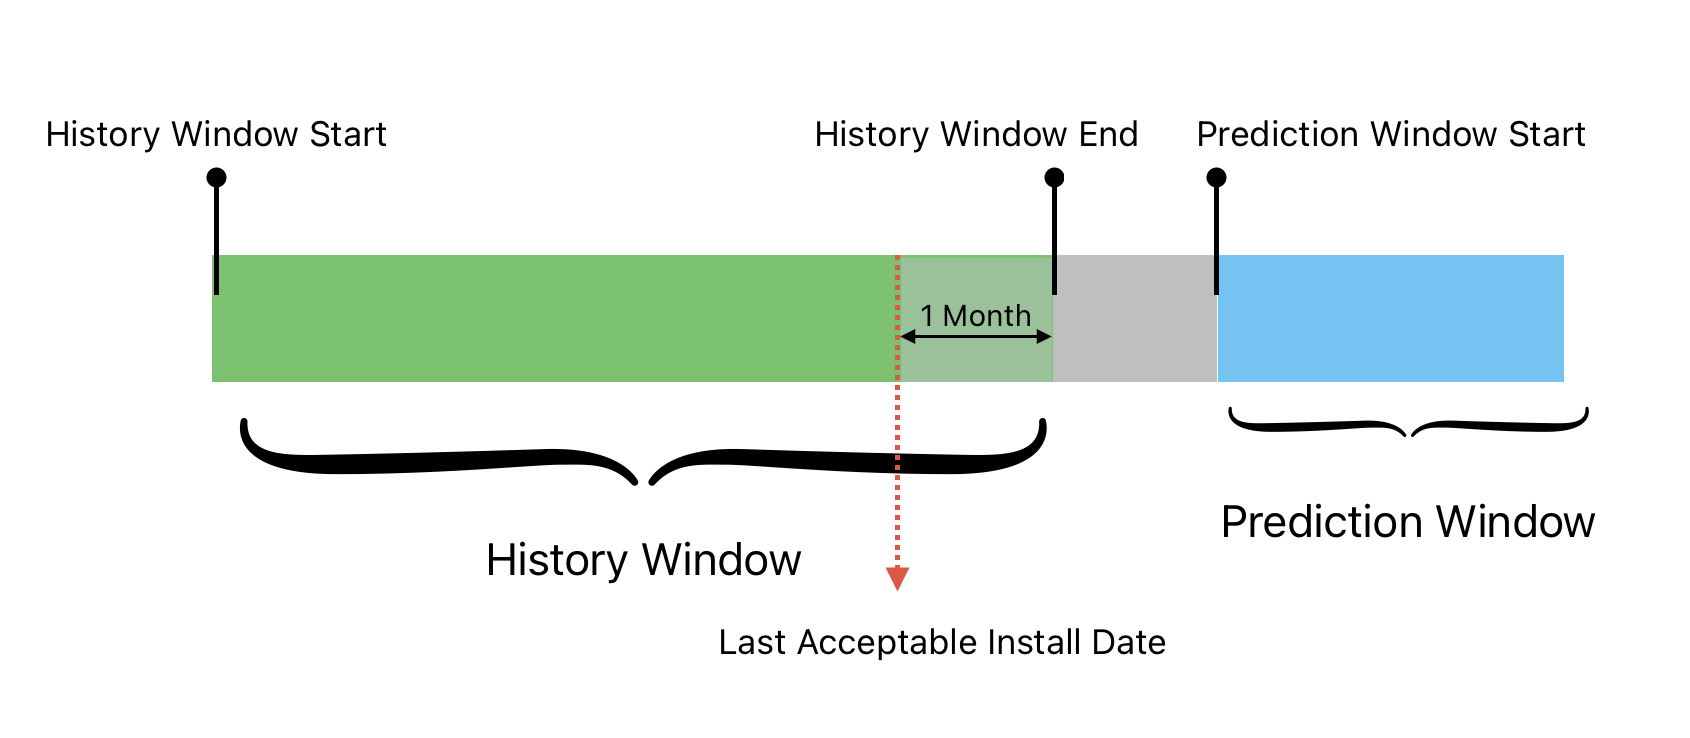

![title](img/churn_def.jpeg)

It's also important to choose the type of our predictive model first, as it affect the structure of data and how it should be prepared.

We have two approaches to choose from:
- The first, simpler approach involves aggregating user data and deriving relevant features without considering time dependency or event sequence. We can then use this data model to train our churn prediction model, capturing the event sequence using appropriate features.

- The second approach focuses on utilizing the event sequence of each customer as our data model. By employing time series related models, we can predict churn by analyzing the chronological order of events.

We kick off our investigation with the first approach. If the results don't quite measure up, we'll give the second one a shot, which is a bit more complicated.

## **Feature Engineering**

In order to  create features in History Window. It's important to only use History window for calculating features and prevent **data leakage** from Prediction window.

In this section we aggregate different event logs to the **user level** in order to create meaningful features for users in a way that captures user behaviour.

Defining let say hyperparameters of our problem, the value of these hyperparameters really depends on business, Also we can test different settings and finally select the one that works best.

In [17]:
history_window_start = pd.to_datetime('2017-04-01', format='%Y-%m-%d')
history_window_end = pd.to_datetime('2017-06-30', format='%Y-%m-%d') # debatable
prediction_window_start = pd.to_datetime('2017-07-01', format='%Y-%m-%d')
install_end_date = history_window_end - DateOffset(months=1)
force_view = 1

As mentioned earlier, we remove those users who joined recently and didn't have enough time to decide.

In [18]:
len_before_removal = df_install.shape[0]

In [19]:
# filter users who have not enough activity
df_install = df_install.loc[df_install['InstallDate'] <= install_end_date]
df_start = df_start.loc[df_start['dateCreated'] <= history_window_end] 
df_view = df_view.loc[df_view['dateCreated'] <= history_window_end] 

In [20]:
(len_before_removal - df_install.shape[0])*100/ len_before_removal # Percentage of data reduction after removal

1.465

Around 1.5% of our dataset would be removed here.

#### Aggregating starts events on user level:
- Average Starting Frequency: How many days it takes a user start our app again on average?
- Average Weekly Starts: How many times a week a user starts our app on average?
- First Start Date
- Last Start Date

In [21]:
# Calculating average days between starts, to have app starting frequency
# How many days it takes a user start our app again on average?
df_start = df_start.sort_values(['userId','dateCreated'])

df_ = df_start.groupby('userId').apply(
    lambda df: (df.dateCreated - df.dateCreated.shift(1)).dt.days).reset_index()

df_ = df_.rename(columns={'dateCreated': 'time_between_starts'})
df_.index = df_.level_1
df_start = df_start.join(df_['time_between_starts'])

# Aggregating Starts Events based on users
df_starts_agg = df_start.groupby('userId').agg(
    first_start = pd.NamedAgg(column='dateCreated', aggfunc='min'),
    last_start = pd.NamedAgg(column='dateCreated', aggfunc='max'),
    avg_starting_frequency = pd.NamedAgg(column='time_between_starts', aggfunc='mean'),
    ).reset_index()

# Calculating average weekly count of starting the app based on users
# How many times a week a user starts our app
df_ = df_start.copy(deep=True)
df_ = df_.assign(count=1).groupby(['userId', pd.Grouper(key='dateCreated', freq='W')])['count'].sum().reset_index()
df_ = df_.groupby('userId').agg(avg_weekly_starts = pd.NamedAgg(column='count', aggfunc='mean'))

# Final aggregated start events at user level
df_starts_agg= pd.merge(df_starts_agg, df_, left_on='userId', right_on='userId', how='left' , validate='one_to_one')

In [22]:
df_starts_agg.head()

,userId,first_start,last_start,avg_starting_frequency,avg_weekly_starts
0,0000bb01-a52b-4b4c-a0dd-8ef80f0a810c,2017-05-08,2017-05-08,NaN,1.0
1,0002c218-d30f-402e-ae08-1280ad4fb669,2017-04-24,2017-04-29,0.625000,9.0
2,000691c6-4289-47f8-81f1-628e52ed5429,2017-04-25,2017-04-25,NaN,1.0
3,00095350-9e64-4b34-9112-b9869703248b,2017-04-07,2017-04-08,1.000000,2.0
4,00095653-80f8-4fba-93d9-44ae70bb6263,2017-05-09,2017-06-21,14.333333,1.0


#### Unified Events
Concatenating install, starts and views events to have all activities of users in one place in order to use it in feature engineering, naming it Event dataframe.
The Event dataframe would be daily aggregated, meaning that each user have only one (at most) record for each day.

In [23]:
# Concatenating install, starts and views events to have all activities of users in one place in order to use it in feature engineering
df_install_ = df_install[['InstallDate','userId']].copy(deep=True).rename(columns={'InstallDate':'dateCreated'})
df_start_ = df_start[['dateCreated','userId']].copy(deep=True)
df_view_ = df_view[['dateCreated','userId']].copy(deep=True)

df_install_['event_type'] = 'install'
df_start_ ['event_type'] = 'start'
df_view_ ['event_type'] = 'view'

df_event = pd.concat([df_install_.assign(event_count=1), df_start_.assign(event_count=1), df_view_.assign(event_count=1)],axis=0, ignore_index= True)
df_event = df_event.groupby(['userId', 'event_type', pd.Grouper(key='dateCreated', freq='d')])['event_count'].sum().reset_index() # daily aggregation

In [24]:
df_event

,userId,event_type,dateCreated,event_count
0,0000bb01-a52b-4b4c-a0dd-8ef80f0a810c,install,2017-05-08,1
1,0000bb01-a52b-4b4c-a0dd-8ef80f0a810c,start,2017-05-08,1
2,0002C218-D30F-402E-AE08-1280AD4FB669,view,2017-04-24,3
3,0002C218-D30F-402E-AE08-1280AD4FB669,view,2017-04-25,3
4,0002C218-D30F-402E-AE08-1280AD4FB669,view,2017-04-26,8
...,...,...,...,...
198800,fffc2810-e6d3-4431-a002-dd713f8f97a1,start,2017-05-13,1
198801,fffc2810-e6d3-4431-a002-dd713f8f97a1,start,2017-05-23,1
198802,fffc2810-e6d3-4431-a002-dd713f8f97a1,start,2017-06-27,1
198803,ffff2596-c930-4f07-a6cc-8cba410359db,install,2017-04-15,1


#### Creating Features out of Event Datafarame
- First Event
- Last Event
- Total number of Events
- Average Weekly Active Days: How many days of a week user was active on average
- Average Activity Frequecy: How many days gap exists between user events on average

In [25]:
# Aggregating events
df_event_agg = df_event.groupby('userId').agg(
    first_event = pd.NamedAgg(column='dateCreated', aggfunc='min'),
    last_event = pd.NamedAgg(column='dateCreated', aggfunc='max'),
    total_event_count = pd.NamedAgg(column='event_count', aggfunc='sum')
    ).reset_index()

In [26]:
# Calculating average active days in a week at user level
df_ = df_event.copy(deep=True)
df_ = df_.assign(count=1).groupby(['userId', pd.Grouper(key='dateCreated', freq='W')])['count'].sum().reset_index()
df_ = df_.groupby('userId').agg(avg_weekly_active_days = pd.NamedAgg(column='count', aggfunc='mean'))

# merge the calculated metric back to the dataframe
df_event_agg = pd.merge(df_event_agg, df_, left_on='userId', right_on='userId', how='left' , validate='one_to_one') # validating there is no duplicate

In [27]:
#Calculating average time between events for each user - if user has one event this value would be null
df_ = df_event[['userId','dateCreated']].copy(deep=True)
df_ = df_.drop_duplicates()
df_ = df_.sort_values(['userId','dateCreated'])
df_ = df_.groupby('userId').apply(
    lambda df: (df.dateCreated - df.dateCreated.shift(1)).dt.days).reset_index()

df_ = df_.rename(columns={'dateCreated': 'time_between_events'})
df_.index = df_.level_1
df_ = df_.groupby('userId').agg( avg_activity_frequency = pd.NamedAgg(column='time_between_events', aggfunc='mean'))

# merge the calculated metric back to the dataframe
df_event_agg = pd.merge(df_event_agg, df_, left_on='userId', right_on='userId', how='left' , validate='one_to_one') # validating there is no duplicate

In [28]:
df_event_agg.head()

,userId,first_event,last_event,total_event_count,avg_weekly_active_days,avg_activity_frequency
0,0000bb01-a52b-4b4c-a0dd-8ef80f0a810c,2017-05-08,2017-05-08,2,2.0,NaN
1,0002C218-D30F-402E-AE08-1280AD4FB669,2017-04-24,2017-04-29,19,5.0,1.25
2,0002c218-d30f-402e-ae08-1280ad4fb669,2017-04-24,2017-04-29,10,6.0,1.25
3,000691c6-4289-47f8-81f1-628e52ed5429,2017-04-25,2017-04-25,2,2.0,NaN
4,00095350-9e64-4b34-9112-b9869703248b,2017-04-07,2017-04-08,8,5.0,1.00


#### Aggregating View events at user level and making features out of it.
- First View
- Last View
- Median of Page turn
- Average view duration

In [29]:
# Aggregating view events at user level
df_view_agg = df_view.groupby('userId').agg(
    last_view = pd.NamedAgg(column='dateCreated', aggfunc='max'),
    first_view = pd.NamedAgg(column='dateCreated',aggfunc='min'),
    med_page_turn = pd.NamedAgg(column='page_turn_count', aggfunc='median'),
    avg_view_duration = pd.NamedAgg(column='view_duration', aggfunc='mean')
    ).reset_index()

df_ = df_view.copy(deep=True)
df_ = df_.groupby(['userId', pd.Grouper(key='dateCreated', freq='W')])['brochure_id'].size().reset_index()
df_ = df_.groupby('userId').agg(avg_weekly_views = pd.NamedAgg(column='brochure_id', aggfunc='mean'))

df_view_agg= pd.merge(df_view_agg, df_, left_on='userId', right_on='userId', how='left' , validate='one_to_one')

In [30]:
df_view_agg.head()

,userId,last_view,first_view,med_page_turn,avg_view_duration,avg_weekly_views
0,0002C218-D30F-402E-AE08-1280AD4FB669,2017-04-29,2017-04-24,10.0,51789.473684,19.000000
1,00095350-9e64-4b34-9112-b9869703248b,2017-04-08,2017-04-07,20.0,70863.0,5.000000
2,00095653-80f8-4fba-93d9-44ae70bb6263,2017-06-18,2017-05-09,4.0,35500.0,1.333333
3,0010E3BE-81BD-48A3-8282-8C8D0B1F9629,2017-06-30,2017-04-18,8.0,67338.9425,37.454545
4,0015a4a8-99f1-4119-9e10-0ac9773ae48a,2017-05-08,2017-05-08,2.0,69000.0,3.000000


Here we merge all different sets of features corresponding to installs, starts, views and events together to have one unified feature table; one row per user.

In [31]:
# Joining all data frames to have a unified table at user level
df_tmp = pd.merge(df_install, df_starts_agg, left_on='userId', right_on='userId', how='left' , validate='one_to_one') # validating there is no duplicate
df_tmp2 = pd.merge(df_tmp, df_event_agg, left_on='userId', right_on='userId', how='left', validate='one_to_one' ) # validating there is no duplicate
df_feature = pd.merge(df_tmp2, df_view_agg, left_on='userId', right_on='userId', how='left' , validate='one_to_one') # validating there is no duplicates

In [32]:
df_feature.head(3)

,id,InstallDate,productId,userId,model,campaignId,first_start,last_start,avg_starting_frequency,avg_weekly_starts,first_event,last_event,total_event_count,avg_weekly_active_days,avg_activity_frequency,last_view,first_view,med_page_turn,avg_view_duration,avg_weekly_views
0,37371890,2017-05-04,de.kaufda.kaufda,5fc13850-de51-4426-96ce-72aaec895abb,"ipad2,7",000000,2017-05-04,2017-05-05,1.000000,2.000000,2017-05-04,2017-05-05,3,3.000000,1.000000,NaT,NaT,<NA>,<NA>,NaN
1,36979918,2017-04-24,com-bonial-kaufda,b13a035e-e9bf-49db-8f93-b49d491bef53,sm-g800f,3iikhy,2017-04-24,2017-05-18,12.000000,1.500000,2017-04-24,2017-05-18,4,2.000000,12.000000,NaT,NaT,<NA>,<NA>,NaN
2,37371070,2017-05-04,de.kaufda.kaufda,5deb0aad-43bb-4ee1-868b-98f36c3d5bbf,"iphone8,4",tl3cy8,2017-05-04,2017-06-11,5.428571,1.333333,2017-05-04,2017-06-11,9,1.333333,6.333333,NaT,NaT,<NA>,<NA>,NaN


Adding more features to enrich the data model.
- Tenure
- Active Age
- Recency
- Has Start
- Has view

In [33]:
def calculate_day_diff(in_date, ref_date):
    return (ref_date - in_date).days

In [34]:
df_feature['tenure'] = df_feature['InstallDate'].apply(calculate_day_diff, args=(history_window_end,)) # user tenure at the end of history window
df_feature['active_age'] = (df_feature['last_event'] - df_feature['first_event']).dt.days
df_feature['recency'] = df_feature['last_event'].apply(calculate_day_diff, args=(prediction_window_start,)) # user recency at the end of history window
df_feature['has_start'] = df_feature['first_start'].notna().astype(int)
df_feature['has_view'] = df_feature['first_view'].notna().astype(int)

Renaming columns to be consistent and easier to use

In [35]:
df_feature.columns

Index(['id', 'InstallDate', 'productId', 'userId', 'model', 'campaignId',
       'first_start', 'last_start', 'avg_starting_frequency',
       'avg_weekly_starts', 'first_event', 'last_event', 'total_event_count',
       'avg_weekly_active_days', 'avg_activity_frequency', 'last_view',
       'first_view', 'med_page_turn', 'avg_view_duration', 'avg_weekly_views',
       'tenure', 'active_age', 'recency', 'has_start', 'has_view'],
      dtype='object')

In [36]:
df_feature.rename(columns={'InstallDate':'install_date',
                           'productId':'product_id',
                           'userId':'user_id',
                           'campaignId':'campaign_id'}, inplace=True)

Dropping date columns and user id as they can't be used in our ML model.

In [37]:
df_x = df_feature.drop(['install_date','first_start','last_start','first_event','last_event','first_view','last_view', 'id'], axis=1)

### Missing Values

Here we don't used interpolation methods or dropping missing values as we have created the features ourselves, we can manually replace missing values by meaningful numbers.

In [38]:
# Filling the null values of created features
df_x.fillna({'avg_starting_frequency':(history_window_end - history_window_start).days,
             'avg_weekly_starts':0,
             'avg_weekly_active_days':0,
             'avg_activity_frequency':(history_window_end - history_window_start).days,
             'med_page_turn':0,
             'avg_view_duration':0,
             'avg_weekly_views':0
             }, inplace=True)

/var/folders/40/1rl713rj2fz3fg_dmczslrl00000gn/T/ipykernel_10379/2023666996.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_x.fillna({'avg_starting_frequency':(history_window_end - history_window_start).days,


In [39]:
df_x.head()

,product_id,user_id,model,campaign_id,avg_starting_frequency,avg_weekly_starts,total_event_count,avg_weekly_active_days,avg_activity_frequency,med_page_turn,avg_view_duration,avg_weekly_views,tenure,active_age,recency,has_start,has_view
0,de.kaufda.kaufda,5fc13850-de51-4426-96ce-72aaec895abb,"ipad2,7",000000,1.000000,2.000000,3,3.000000,1.000000,0.0,0.0,0.0,57,1,57,1,0
1,com-bonial-kaufda,b13a035e-e9bf-49db-8f93-b49d491bef53,sm-g800f,3iikhy,12.000000,1.500000,4,2.000000,12.000000,0.0,0.0,0.0,67,24,44,1,0
2,de.kaufda.kaufda,5deb0aad-43bb-4ee1-868b-98f36c3d5bbf,"iphone8,4",tl3cy8,5.428571,1.333333,9,1.333333,6.333333,0.0,0.0,0.0,57,38,20,1,0
3,com-bonial-kaufda,64707e97-d5e1-4622-a89a-bebf8432fd33,sm-g955f,000000,4.642857,2.500000,27,3.333333,5.000000,25.0,51818.181818,2.2,69,65,5,1,1
4,com-bonial-kaufda,770a391d-eda5-423b-b672-845f1e12661f,sm-j320h,000000,2.000000,2.000000,20,4.500000,2.000000,18.0,93333.333333,7.5,76,6,71,1,1


In [40]:
df_x.isnull().sum()

product_id                 0
user_id                    0
model                     37
campaign_id                0
avg_starting_frequency     0
avg_weekly_starts          0
total_event_count          0
avg_weekly_active_days     0
avg_activity_frequency     0
med_page_turn              0
avg_view_duration          0
avg_weekly_views           0
tenure                     0
active_age                 0
recency                    0
has_start                  0
has_view                   0
dtype: int64

Calculating the percentage of missing values in our dataset, if it was small we can drop the rows with missing values.

In [41]:
# Missing Value Percentage
df_x['model'].isnull().sum()/len(df_x['model'])

0.0018775054549144974

Because the percentage of missing values left in `model` columns is small we can drop the rows with missing model.

In [42]:
df_x.dropna(subset=['model'], axis=0, inplace= True)

## How many user viewed or start the app after install?

Assuming the user journey as:

 ### ***Install -> Start -> View***

Lets check the percentage of user drop-off at each stage.




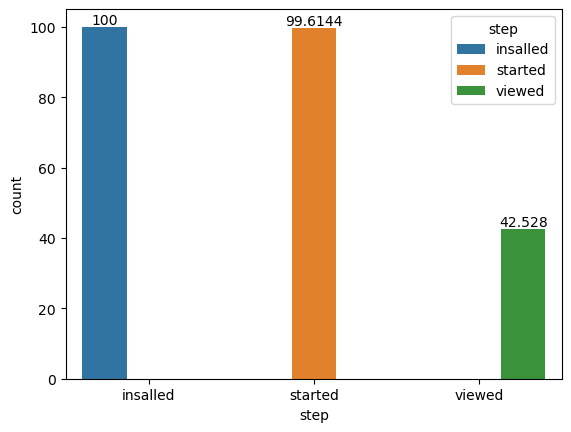

In [43]:
# Visualizing customer drops in different steps
data_viz = [['insalled', 100* df_feature.user_id.size/df_feature.user_id.size],
            ['started', 100*df_feature.has_start.sum()/df_feature.user_id.size],
            ['viewed', 100*df_feature.has_view.sum()/df_feature.user_id.size]]

df_viz = pd.DataFrame(data_viz, columns=['step', 'count'])
# df_viz.plot.bar(x='step',y='count')
ax = sns.barplot(df_viz, x='step', y='count', hue="step")
for i in ax.containers:
    ax.bar_label(i,)

**The plot above shows only 42 percent of users viewed brochures over the history window.**

#### **Business Insights:**

Doing analysis on the user data to found the causes of this drop-off like:
- Checking the load time of first pages and brocures.
- Check recomendation model for brochures on the cases that user is in the cold start.
- Engage Users with Onboarding
- Push Notifications: Implement a well-thought-out push notification strategy to re-engage users.
- Collect feedback from users who drop the app to understand their reasons (Hard to get!)
- Implement A/B testing to optimize user engagement strategies

# Defining Churn and Calculating Lables
We classify churn as the absence of any activity. Hence, if a user started the app or viewed any brochures during the target month, we consider them as not having churned.

In [44]:
active_view = df_view_target['userId'].drop_duplicates().rename('user_id')
active_start = df_start_target['userId'].drop_duplicates().rename('user_id')
active_users = pd.concat([active_view, active_start]).drop_duplicates()

In [45]:
# Calculating Churn label
df = pd.merge(df_x, active_users, left_on='user_id', right_on='user_id', how='left' , validate='one_to_one', indicator=True)
df['churn'] = np.where(df['_merge']== 'both', 0, 1)
df = df.drop(columns=['_merge'])

**Churn Rate:**

In [46]:
# Churn Rate
100* df['churn'].sum()/df['user_id'].nunique()

75.47025927808846

**Churn Rate by Product:**

Calculating Churn rate for each product:

In [47]:
# Churn Rate by Product
df_churn_product = df.groupby('product_id').agg(
    churn = pd.NamedAgg(column='churn', aggfunc='sum'),
    total = pd.NamedAgg(column= 'user_id', aggfunc=pd.Series.nunique)
).reset_index()
df_churn_product['churn_rate'] = 100*df_churn_product['churn']/df_churn_product['total']
df_churn_product.head()

,product_id,churn,total,churn_rate
0,com-bonial-kaufda,6590,9585,68.753260
1,de-kaufda-android,5985,6764,88.483146
2,de.kaufda.kaufda,2270,3321,68.352906


Visualizing the result

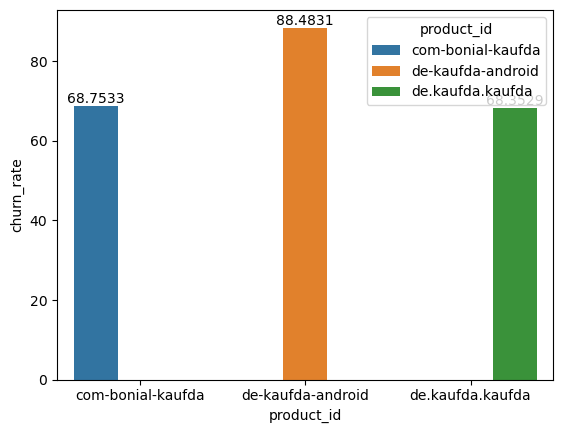

In [48]:
# df_churn_product.plot.bar(x='product_id', y='churn_rate', rot=0)
ax = sns.barplot(df_churn_product, x='product_id', y='churn_rate', hue="product_id")
for i in ax.containers:
    ax.bar_label(i,)

As you can see in the figure, the churn rate in `Kaufda Androind App` is significantly higher compare to other two products

#### **Business Insights:**
- Ensure that the app is fast, responsive, and free of technical issues. Users are more likely to churn if they encounter frequent crashes, slow load times, or bugs.
- Gather and analyze user feedback and reviews for the Kaufda androind app. This will help you understand what users dislike or find lacking in the app
- Check if any feature is available in website that missed in android app
- Segment customer base to identify the root causes. Are there specific user groups or demographics experiencing higher churn?

In [49]:
import plotly.express as px
fig = px.scatter(x=df['tenure'], y=df['total_event_count'],
                 color = df['churn'], template = 'presentation',
                 opacity = 0.5, facet_col = df['product_id'],
                 title = 'Customer Churn by Tenure, Event Count, and Product',
                 labels = {'x' : 'Customer Tenure', 'y' : 'Total Event #'})

fig.show()

The figure above shows Churn by Customer Tenure and Number of Events for each Product. The figure shows that the users who use bonial-kaufda are more active compare to the other platforms. 

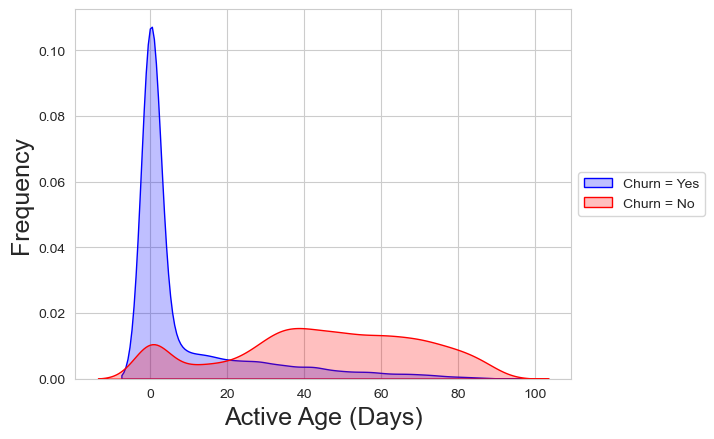

In [50]:
sns.set_style('whitegrid')
g1 = sns.kdeplot(df[df['churn'] == 1]['active_age'], fill=True, color="b", label='Churn = Yes')
g1 = sns.kdeplot(df[df['churn'] == 0]['active_age'], fill=True, color="r", label='Churn = No')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Active Age (Days)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

In [51]:
df.columns

Index(['product_id', 'user_id', 'model', 'campaign_id',
       'avg_starting_frequency', 'avg_weekly_starts', 'total_event_count',
       'avg_weekly_active_days', 'avg_activity_frequency', 'med_page_turn',
       'avg_view_duration', 'avg_weekly_views', 'tenure', 'active_age',
       'recency', 'has_start', 'has_view', 'churn'],
      dtype='object')

## Final Model features and Description:

| Feature Name           | Description |
|----------------------- |-------------|
| product_id             | Different native apps that we have on the market |
| model                  | Smartphone device name |
| campaign_id            | Indicates how the user installed the app|
| avg_starting_frequency | Average days between starting the app|
| avg_weekly_starts      | Average number of starts per week|
| total_event_count      | Total number of activities including start, view and install|
| avg_weekly_active_days | Average weekly number of days user had activity on|
| avg_activity_frequency | Average days between activities|
| med_page_turn          | Median of page turns in views |
| recency                | Days between last activity and end history end date|
| has_start              | If user has started the app ever|
| has_view               | If user viewed any brochure ever|
| churn                  | If user churn in prediction window or not|

Now we have created our dataset to be used in model training and evaluation, the data is stored in `df` dataframe

## Feature Selection

Here we need to first split Train and Test set before feature selection in order to prevent data leakage from test set to training set.

In [52]:
from sklearn.model_selection import train_test_split

df = df.drop(columns=['user_id'])
# Extract feature and target
X, y = df.drop('churn', axis=1), df[['churn']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In this section, we assess the correlation between features and eliminate highly correlated ones. High correlation among features can adversely affect the stability, interpretability, and efficiency of the model. Therefore, we take the necessary steps to address this issue by removing features that exhibit strong correlations.

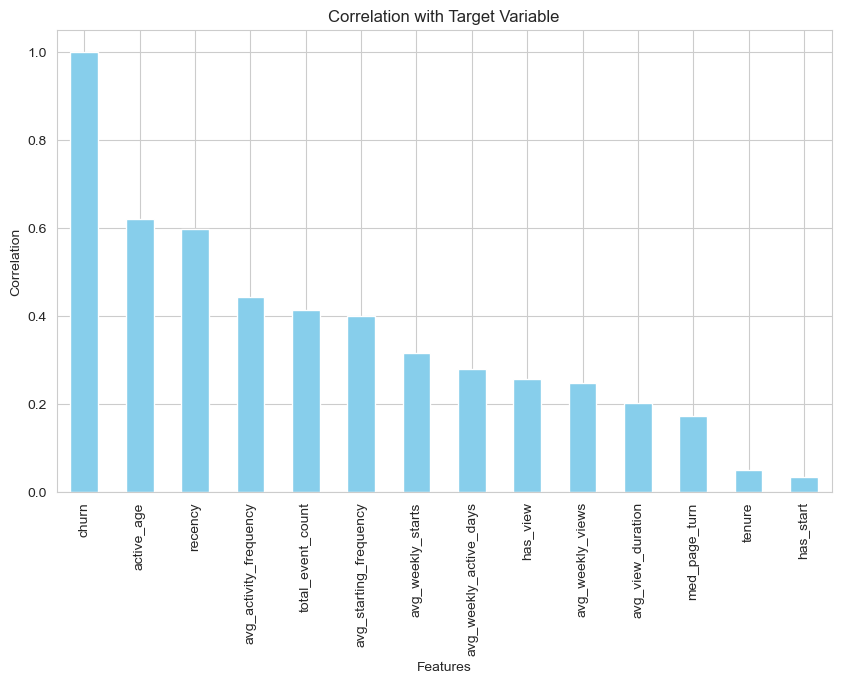

In [53]:

# Calculate the correlation matrix
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr(numeric_only=True)

# Calculate the correlation of features with the target variable
correlation_with_target = correlation_matrix['churn']

# This will give you a Series with correlation values for each feature
# You can sort it to see the most correlated features
sorted_correlation = correlation_with_target.abs().sort_values(ascending=False)

# Create a bar plot to visualize correlations
plt.figure(figsize=(10, 6))
sorted_correlation.plot(kind='bar', color='skyblue')
plt.title("Correlation with Target Variable")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

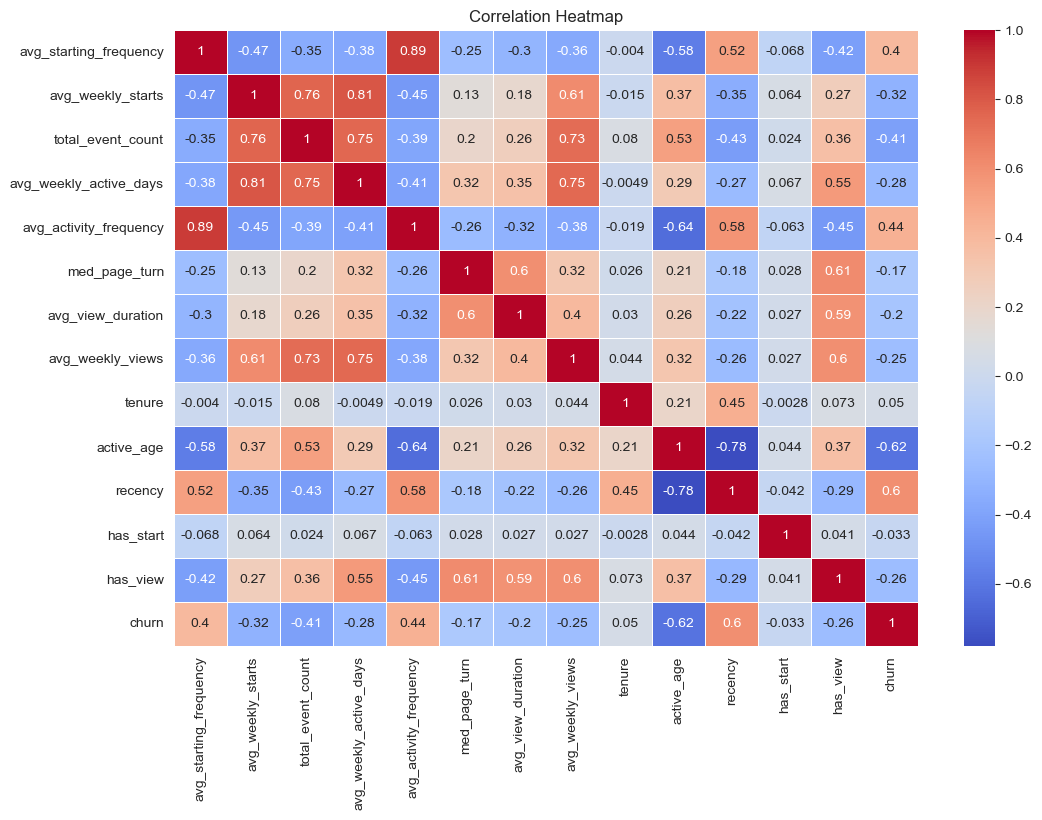

In [54]:
# Set up the figure and axis
plt.figure(figsize=(12, 8))

# Create a correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Heatmap")
plt.show()

Removing highly correlated features

In [55]:
correlation_matrix = X_train.corr(numeric_only=True).abs()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
tri_df = correlation_matrix.mask(mask)
highly_correlated_features = [c for c in tri_df.columns if any(tri_df[c]> 0.8)]


In [56]:
highly_correlated_features

['avg_starting_frequency', 'avg_weekly_starts']

Removing Highly correlated features

In [57]:
# Remove Highly correlated features from train and test data
X_train = X_train.drop(columns=highly_correlated_features)
X_test = X_test.drop(columns=highly_correlated_features)

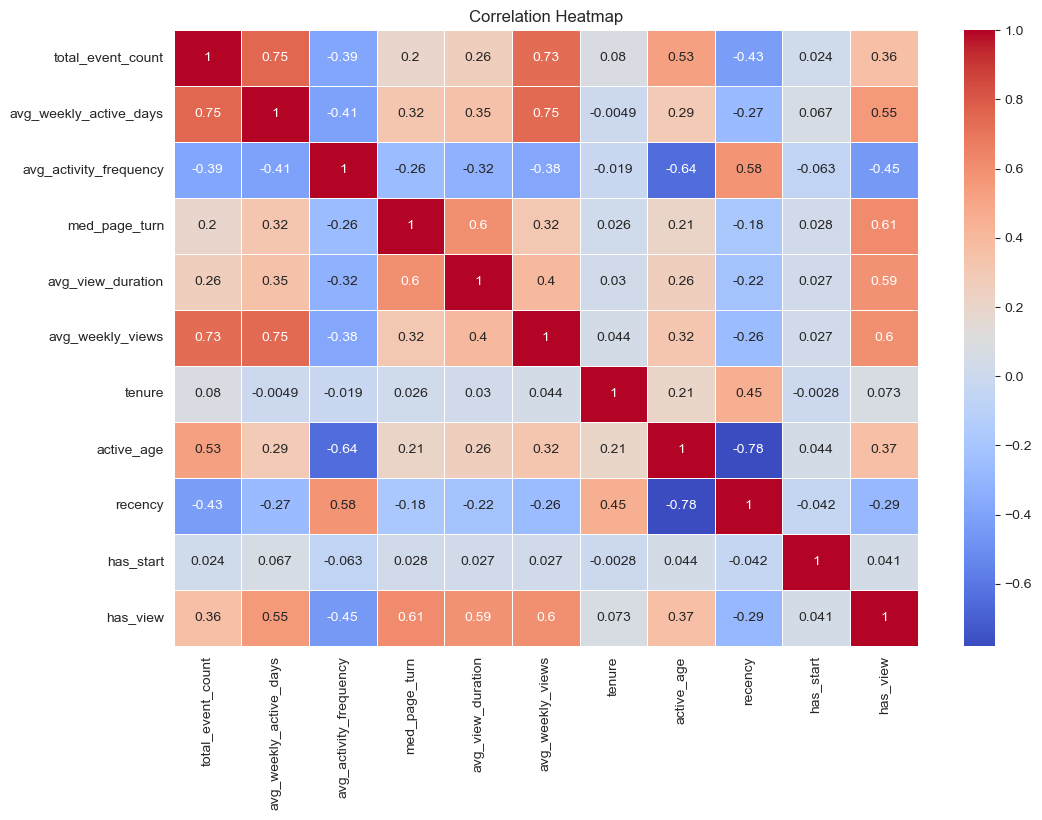

In [58]:
# Create a correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(numeric_only=True), annot=True, cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Heatmap")
plt.show()

### Encoding Categorical Features

In [59]:
import category_encoders as ce

# df = pd.get_dummies(df, columns=['product_id'], prefix='product')
encoder = ce.TargetEncoder(cols=['product_id','campaign_id','model'], return_df=True)
X_train = encoder.fit_transform(X_train, y_train)

Calculating feature importance of our new set of features using random forest classification.

/Users/milad/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



<Figure size 1000x600 with 0 Axes>

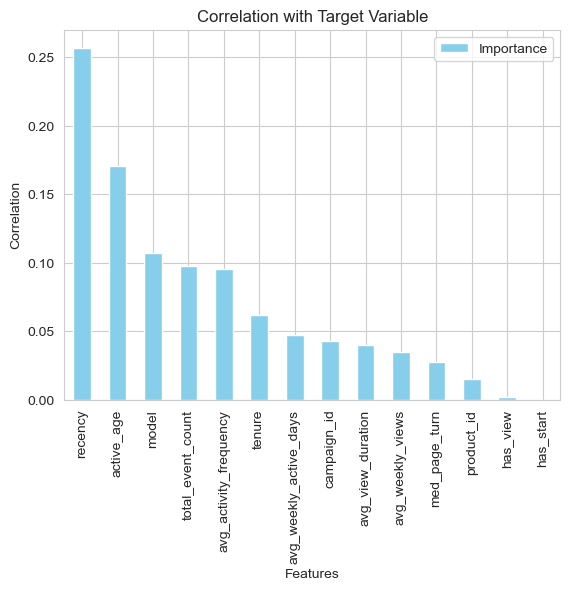

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing


# Initialize the Random Forest model
rf = RandomForestClassifier()

# Fit the model to the data
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importance
# print(feature_importance_df)
# Create a bar plot to visualize correlations
plt.figure(figsize=(10, 6))
feature_importance_df.plot(x='Feature',y='Importance', kind='bar', color='skyblue')
plt.title("Correlation with Target Variable")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

In [61]:
X_test = encoder.transform(X_test)

# Handling Imbalanced Data

As we can see from the result below, if we look at the problem as a two class classification problem; the number of samples in these two class are not consistent and we have an imbalanced classification problem.

In [62]:
y_train.groupby('churn').size()

churn
0     3859
1    11877
dtype: int64

For Handling imbalance we oversample the minority class with SMOTE method. SMOTE stands for Synthetic Minority Oversampling Technique.

> SMOTE picks an instance randomly from the minority class. Then it finds its k nearest neighbors from the minority class itself. Then one of the neighbors gets chosen randomly and draws the line between these two instances. Then new synthetic examples are generated using a convex combination of these two instances

In [63]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [64]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

**Taking a closer and more in-depth look at our ultimate dataset.**

In [65]:
#profile = ProfileReport(df_train, title="Profiling Report")
#profile

## Choosing ML Model

Now we have our dataset ready and we can start developing our predictive model.

Here are the steps:
- Nomalizing the features
- Choosing an ML Model
- Training the model
- Tuning it's hyperparameters
- Evaluate the model

In [66]:
# init setup
from pycaret.classification import *

In [67]:
# Init setup
s = setup(data=df_train ,test_data=df_test , target = 'churn', session_id = 123, normalize = True, normalize_method = 'minmax', index=False)

,Description,Value
0,Session id,123
1,Target,churn
2,Target type,Binary
3,Original data shape,"(27688, 15)"
4,Transformed data shape,"(27688, 15)"
5,Transformed train set shape,"(23754, 15)"
6,Transformed test set shape,"(3934, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


In [68]:
# Compare models
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9063,0.9624,0.9316,0.8964,0.9111,0.8127,0.8184,0.1970
rf,Random Forest Classifier,0.9025,0.9565,0.8974,0.9118,0.9032,0.8051,0.8076,0.2670
et,Extra Trees Classifier,0.8992,0.9533,0.8822,0.9168,0.8982,0.7984,0.8005,0.1530
gbc,Gradient Boosting Classifier,0.8885,0.9486,0.9098,0.8758,0.8916,0.7770,0.7792,0.3890
ada,Ada Boost Classifier,0.8715,0.9354,0.8889,0.8608,0.8741,0.7430,0.7442,0.1030
knn,K Neighbors Classifier,0.8739,0.9304,0.8676,0.8806,0.8736,0.7478,0.7488,0.0600
lda,Linear Discriminant Analysis,0.8584,0.9170,0.8699,0.8509,0.8601,0.7168,0.7172,0.0140
lr,Logistic Regression,0.8466,0.9070,0.8512,0.8434,0.8473,0.6931,0.6932,0.1600
nb,Naive Bayes,0.8105,0.8773,0.7707,0.8383,0.8008,0.6210,0.6249,0.0110
dt,Decision Tree Classifier,0.8541,0.8566,0.8548,0.8600,0.8556,0.7083,0.7113,0.0300


Create gradient boosting classification model as it outperforms the rest in most of the measures.

In [69]:
xgb_model = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8300,0.9141,0.9428,0.7692,0.8472,0.6599,0.6774
1,0.8321,0.9138,0.9495,0.7689,0.8497,0.6641,0.6833
2,0.8245,0.9052,0.9352,0.7657,0.8420,0.6490,0.6655
3,0.9078,0.9668,0.9242,0.8949,0.9093,0.8157,0.8161
4,0.9398,0.9857,0.9167,0.9612,0.9384,0.8796,0.8805
5,0.9478,0.9891,0.9335,0.9610,0.9471,0.8956,0.8959
6,0.9419,0.9860,0.9318,0.9510,0.9413,0.8838,0.8840
7,0.9491,0.9895,0.9250,0.9717,0.9478,0.8981,0.8991
8,0.9478,0.9866,0.9292,0.9650,0.9468,0.8956,0.8962


### Hyperparameter Tuning

Tuning the hyperparameters of the gradient boosting model

In [70]:
tuned_xgb = tune_model(xgb_model, n_iter=50)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:05:48
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


## Model Evaluation

For Evaluating our trained model first we can plot Confusion Matrix to check the performance of the classifier in each class.

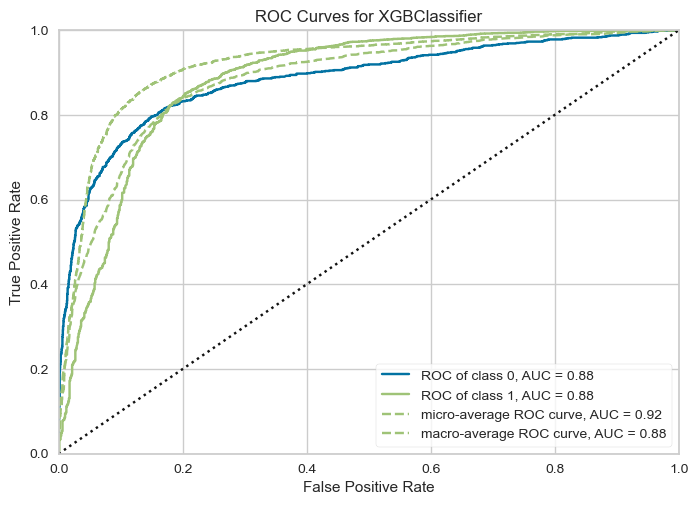

In [ ]:
# Plot AUC
plot_model(tuned_xgb, plot = 'auc')

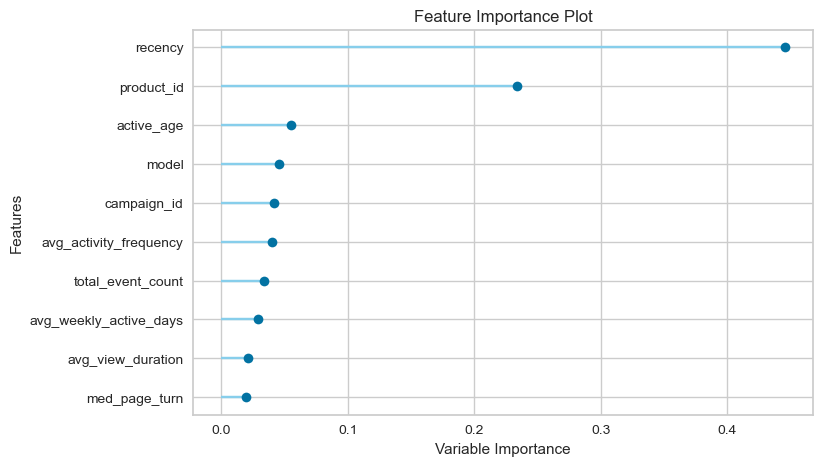

In [ ]:
# plot feature importance
plot_model(tuned_xgb, plot = 'feature')

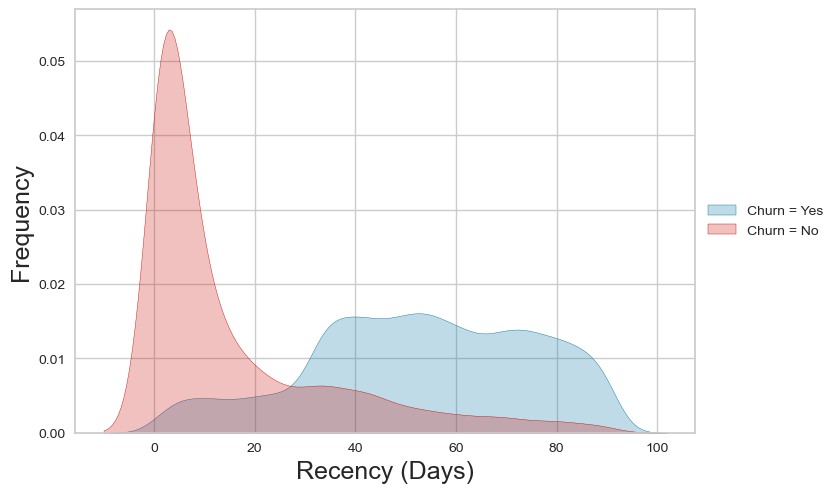

In [ ]:
sns.set_style('whitegrid')
g1 = sns.kdeplot(df[df['churn'] == 1]['recency'], fill=True, color="b", label='Churn = Yes')
g1 = sns.kdeplot(df[df['churn'] == 0]['recency'], fill=True, color="r", label='Churn = No')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Recency (Days)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

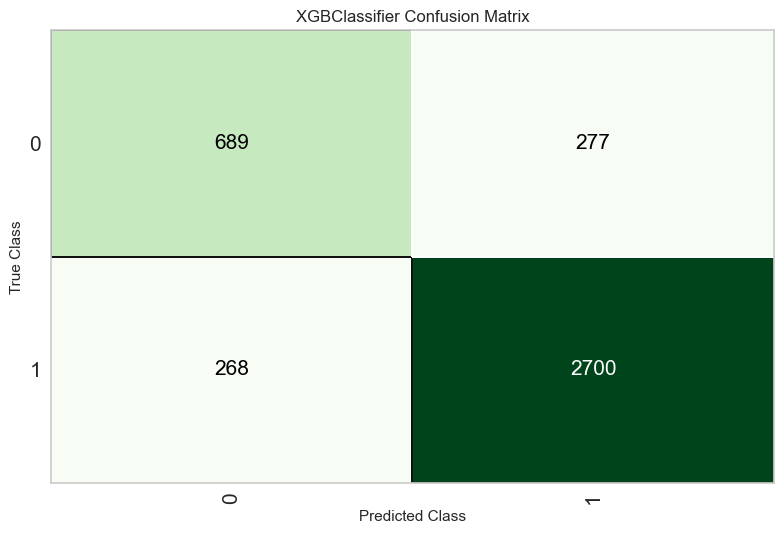

In [ ]:
# Plot confusion matrix
plot_model(tuned_xgb, plot = 'confusion_matrix')

## Prediction

Now, we evaluate the model by making predictions on the test set that we had previously set aside and assess its performance.

In [ ]:
# Predict on test set
holdout_pred = predict_model(tuned_xgb)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8615,0.8837,0.9097,0.9070,0.9083,0.6249,0.6249


In [ ]:
# Show predictions
holdout_pred.head()

,product_id,model,campaign_id,total_event_count,avg_weekly_active_days,avg_activity_frequency,med_page_turn,avg_view_duration,avg_weekly_views,tenure,active_age,recency,has_start,has_view,churn,prediction_label,prediction_score
23754,0.688724,0.528456,0.754853,4,4.0,5.0,3.0,9000.0,1.0,87,5,83,1,1,1,1,0.9061
23755,0.688724,0.786673,0.753965,2,2.0,90.0,0.0,0.0,0.0,86,0,87,1,0,1,1,0.9866
23756,0.688724,0.922886,0.857122,7,3.0,21.5,6.0,58585.0,1.5,55,43,13,1,1,0,1,0.8590
23757,0.688724,0.751103,0.754853,2,2.0,90.0,0.0,0.0,0.0,53,0,54,1,0,1,1,0.9050
23758,0.688724,0.721313,0.754853,3,3.0,1.0,0.0,0.0,0.0,74,1,74,1,0,1,1,0.9830


In [ ]:
print(tuned_xgb)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)


## Extra (Hyperparameter Search)

In this section my goal is to train and fine tune XGboost manually in order to check if I can get better result compared to automated pipelines of Pycaret.

In [78]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [79]:
model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

In [80]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=4, num_parallel_tree=None,
              objective='binary:logistic', ...)

In [81]:
y_pred = model.predict(X_test)

In [82]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8624809354346721
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.79      0.74       966
           1       0.93      0.89      0.91      2968

    accuracy                           0.86      3934
   macro avg       0.81      0.84      0.82      3934
weighted avg       0.87      0.86      0.87      3934



In [83]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
print("Classification Report for Best Model:\n", report)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best Model Accuracy: 0.8647686832740213
Classification Report for Best Model:
               precision    recall  f1-score   support

           0       0.72      0.73      0.72       966
           1       0.91      0.91      0.91      2968

    accuracy                           0.86      3934
   macro avg       0.82      0.82      0.82      3934
weighted avg       0.86      0.86      0.86      3934



## What other data points would increase the accuracy of the algorithm?

At the moment, our dataset primarily consists of view events related to brochures. To enhance the model's accuracy, it would be beneficial to incorporate click data on brochures and user purchase information. Additionally, given that offer recommendations and rankings are significantly influenced by customer location, including geographical information would further enhance the model's performance.